[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/Foundation_Model_Digit_Classification_ViT.ipynb)

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

!pip install einops
from einops import rearrange, repeat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 902.5 kB/s eta 0:00:00


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

In [ ]:
# Setup training data
train_data = datasets.MNIST(
    root=".", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.MNIST(
    root=".",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# See first training sample
image, label = train_data[0]
print(f'''Image Shape : {image.shape}''')

print('')
print(f'''Total Training Data (X) : {len(train_data.data)}''')
print(f'''Total Training Data (Y) : {len(train_data.targets)}''')
print(f'''Training Classes : {train_data.classes}''')

print('')
print(f'''Total Training Data (X) : {len(test_data.data)}''')
print(f'''Total Training Data (Y) : {len(test_data.targets)}''')

100%|██████████| 9912422/9912422 [00:00<00:00, 177300436.45it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 103182022.00it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46114550.69it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5367858.20it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Image Shape : torch.Size([1, 28, 28])

Total Training Data (X) : 60000
Total Training Data (Y) : 60000
Training Classes : ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Total Training Data (X) : 10000
Total Training Data (Y) : 10000


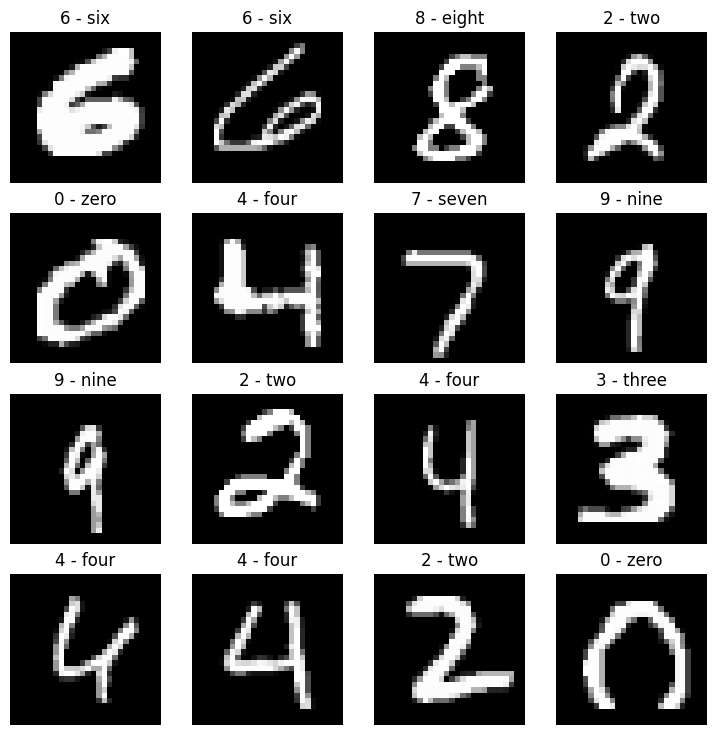

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

## Dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32,shuffle=True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

print(f"Features Batch Size {train_features_batch.shape}")
print(f"Labels Batch Size {train_labels_batch.shape}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 1875 batches of 32


In [ ]:
test_dataloader = DataLoader(test_data, batch_size=32,shuffle=False)
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(f"Features Batch Size {test_features_batch.shape}")
print(f"Labels Batch Size {test_labels_batch.shape}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of 32")

Features Batch Size torch.Size([32, 1, 28, 28])
Labels Batch Size torch.Size([32])
Length of train dataloader: 313 batches of 32


## Modelling

In [ ]:
class ViT(nn.Module):

    def __init__(self, img_size:int=28, in_channels:int=1, patch_size:int=4, embedding_dim:int=768, mlp_size:int=3072, num_classes:int=1000):
        super().__init__()

        self.patch_embedding = nn.Sequential(nn.LayerNorm(1*4*4), nn.Linear(1*4*4, 768), nn.LayerNorm(768))

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        num_patches = (img_size // patch_size) * (img_size // patch_size)
        # num_patches = (img_size * img_size) // patch_size**2
        self.position_embedding = nn.Parameter(data=torch.randn(1, num_patches+1, embedding_dim),requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=0.1)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                                  nhead=2,
                                                                                                  dim_feedforward=mlp_size,
                                                                                                  activation="gelu",
                                                                                                  batch_first=True,
                                                                                                  norm_first=True), # Create a single Transformer Encoder Layer
                                                        num_layers=2) # Stack it N times
        self.classifier = nn.Sequential( nn.LayerNorm(normalized_shape=embedding_dim), nn.Linear(in_features=embedding_dim, out_features=num_classes))


    def forward(self, x):

        # 32, 1, 28, 28 -> 32, 1, 7*4, 7*4 -> 32, 1, 7, 7, 4, 4 -> 32, 7, 7, 4, 4, 1 -> 32, 7*7, 4*4*1 - > 32, num_patches, patch_dim
        x = rearrange(x, 'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)', ph=4, pw=4)

        # Create patch embedding for all images in the batch
        x = self.patch_embedding(x)

        # Create class embedding and expand it to match the batch size.
        class_token = self.class_embedding.expand(x.shape[0], -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # Concat class embedding with the patch embedding
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding
        x = self.position_embedding + x

        # 17. Run embedding dropout
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
torch.manual_seed(42)
model = ViT(num_classes=10).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

In [ ]:
torch.manual_seed(42)
for epoch in tqdm(range(3)): # running for 3 epochs

    print(f"Epoch: {epoch}\n-------")

    '''
    TRAINING
    '''
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X) #Forward pass

        loss = loss_fn(y_pred, y) # Calculate loss (per batch)
        acc = accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

        train_loss += loss # accumulatively add up the loss per epoch
        train_acc += acc # Go from logits -> pred labels

        optimizer.zero_grad() # Optimizer zero grad
        loss.backward() # Loss backward
        optimizer.step() # Optimizer step

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    '''
    TESTING
    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X) # Forward pass

            loss = loss_fn(test_pred, y)
            acc = accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

            test_loss += loss
            test_acc += acc

        # Calculations on test metrics need to happen inside torch.inference_mode()
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Test loss: {test_loss:.5f}  | Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 1.19255 | Train accuracy: 71.23%
Test loss: 0.26861  | Test acc: 91.39%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.32025 | Train accuracy: 89.90%
Test loss: 0.17592  | Test acc: 94.44%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.23886 | Train accuracy: 92.42%
Test loss: 0.19691  | Test acc: 93.63%



## Inference

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
torch.manual_seed(42)
eval_model(model=model, data_loader=test_dataloader,loss_fn=loss_fn, accuracy_fn=accuracy_fn)

{'model_name': 'ViT',
 'model_loss': 0.19690898060798645,
 'model_acc': 93.63019169329074}

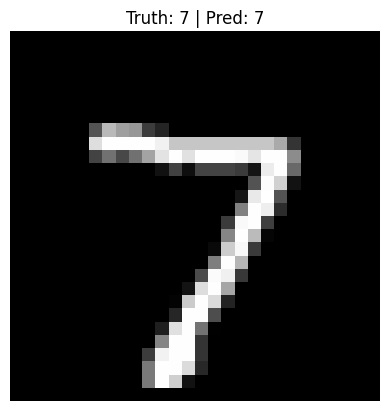

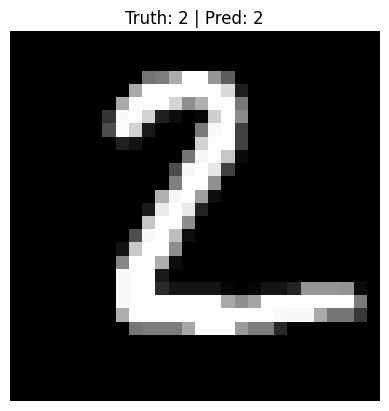

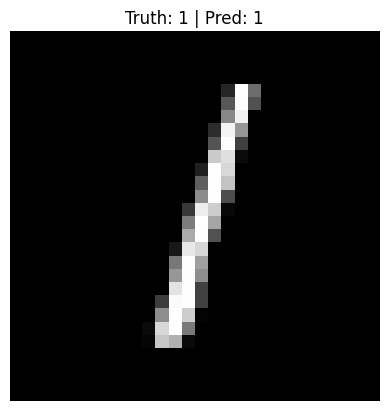

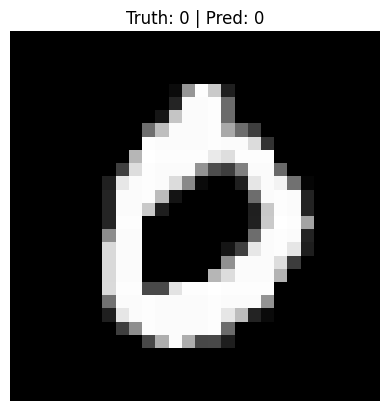

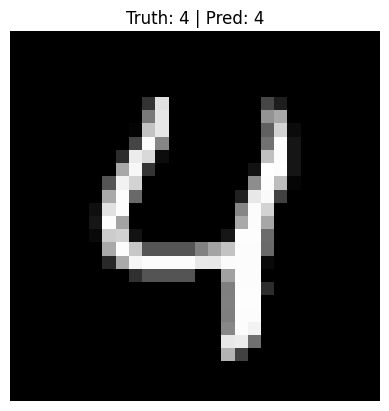

In [ ]:
# making predictions for 5 images
for i in range(5):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  model_pred_logits = model(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  # Plot the image and prediction
  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}")
  plt.axis(False);